# SC01 - Semantic Layer Consumption Example


## Purpose of This Notebook

This notebook intentionally avoids complex analysis or modeling.

Its sole purpose is to **validate the analytical contracts** established by the SC01 semantic layer:
- that each view exposes a stable and well-defined grain,
- that joins are deterministic and free of duplication,
- and that analytical datasets can be assembled reproducibly without downstream correction.

The notebook demonstrates how analysts are expected to consume the semantic layer:
- querying only curated views,
- joining at explicit keys,
- and performing minimal reshaping strictly for analysis.

The focus is not on results, but on **trustworthy data consumption patterns**.

## Section 0: Setup & Configuration

In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

sys.path.insert(0, str(Path.cwd().parent / 'src'))

from loaders import load_semantic_views, resolve_repo_root, load_database_url
from plots import plot_uts_histogram, plot_uts_boxplot

plt.style.use('ggplot')


## Section 1: Load Semantic Views

Choose your data source:
- **CSV** (default): No dependencies, works offline
- **PostgreSQL**: See SQL queries in action, requires DB running

Both return data in the same format.


Load three semantic views:
1. `v_heats_by_alloy`: 1 row per heat (alloy assignment)
2. `v_heats_by_final_product`: 1 row per heat (product metadata)
3. `v_lab_values_by_heats`: multiple rows per heat (lab results)
4. `v_analysis_dataset` : analysis ready view for comparsion with df built with pandas

The same code works for both CSV and PostgreSQL.

In [2]:
repo_root = resolve_repo_root()
database_url = load_database_url(repo_root)
DATA_SOURCE = 'postgresql'

loaded = load_semantic_views(
    data_source=DATA_SOURCE,
    repo_root=repo_root,
    database_url=database_url
)

df_heats_alloy = loaded['df_heats_alloy']
df_final_prod = loaded['df_final_prod']
df_lab = loaded['df_lab']
df_sql = loaded['df_sql']

print('✓ Loaded semantic views:\n')
print(f'  - source: {loaded['data_source']}')
print(f'  - v_heats_by_alloy: {len(df_heats_alloy)} rows')
print(f'  - v_final_product: {len(df_final_prod)} rows')
print(f'  - v_lab_values: {len(df_lab)} rows')
print(f'  - v_lab_values: {len(df_sql)} rows\n')

✓ Loaded semantic views:

  - source: postgresql
  - v_heats_by_alloy: 2200 rows
  - v_final_product: 2200 rows
  - v_lab_values: 6600 rows
  - v_lab_values: 2200 rows



## Section 2: Grain Validation

**Critical:** Verify the semantic layer respects heat-level grain contracts.

Expected grain:
- `v_heats_by_alloy`: 1 row per heat
- `v_final_product`: 1 row per heat
- `v_lab_values`: 1 row per (heat, test_name, session_type)

This prevents silent errors in joins.

In [ ]:
# ============================================================================
# SECTION 2: Grain Validation
# ============================================================================

print('\n' + '=' * 80)
print('GRAIN VALIDATION (Core to SC01)')
print('=' * 80 + '\n')

# Validate v_heats_by_alloy
grain_alloy = df_heats_alloy.groupby('heat_id').size()
assert grain_alloy.max() == 1, 'ERROR: Duplicates in v_heats_by_alloy'
print(f'✓ v_heats_by_alloy: 1 row per heat ({len(df_heats_alloy)} heats)')

# Validate v_final_product
grain_product = df_final_prod.groupby('heat_id').size()
assert grain_product.max() == 1, 'ERROR: Duplicates in v_final_product'
print(f'✓ v_final_product: 1 row per heat ({len(df_final_prod)} heats)')

# Validate v_lab_values
lab_key = df_lab.groupby(['heat_id', 'test_name']).size()
assert lab_key.max() == 1, 'ERROR: Duplicates in v_lab_values'
print(f'✓ v_lab_values: No duplicates within (heat, test, session)')

# Check alignment
common_heats = set(df_heats_alloy['heat_id']) & set(df_final_prod['heat_id'])
print(f'\n✓ {len(common_heats)} heats in both alloy and product views')
print('\n✓ GRAIN CONTRACTS VALIDATED')


GRAIN VALIDATION (Core to SC01)

✓ v_heats_by_alloy: 1 row per heat (2200 heats)
✓ v_final_product: 1 row per heat (2200 heats)
✓ v_lab_values: No duplicates within (heat, test, session)

✓ 2200 heats in both alloy and product views

✓ GRAIN CONTRACTS VALIDATED


## Section 3: Build Analysis-Ready Dataset

### Two Approaches to the Same Result

In this section, we demonstrate the core value proposition of a semantic layer:

**Approach 1 (Pandas):** Explicitly construct the analysis dataset by pivoting lab values and joining semantic views. This shows the *logic* behind data construction—each step is visible and debuggable.

**Approach 2 (SQL View):** Load pre-built dataset directly from `v_analysis_dataset` view. This demonstrates the *efficiency* gain: the analyst writes one line of SQL instead of multiple pandas operations.

### Why This Matters

With a well-designed semantic layer:
- **Reduced complexity:** Analysts work with curated views, not raw tables
- **Formal data contracts:** Grain, column names, and transformations are standardized
- **Less boilerplate:** No need to rewrite pivot/join logic across projects
- **Single source of truth:** Data definition lives in database, not notebooks

The comparison in **Section 3B** validates that both approaches produce identical results, proving the semantic layer abstraction is correct and trustworthy.

**Approach 1 - Pandas:**

Create 1 row per heat by:
1. Pivoting lab results (test_name → columns)
2. Inner join on heat_id

This replaces multi-file spreadsheet merges.

In [ ]:
# ============================================================================
# SECTION 3: Build Analysis-Ready Dataset
# ============================================================================

print('\n' + '=' * 80)
print('BUILDING ANALYSIS-READY DATASET')
print('=' * 80 + '\n')

# Pivot lab results wide
lab_wide = (
    df_lab.pivot_table(
        index='heat_id',
        columns='test_name',
        values='test_value',
        aggfunc='mean'
    )
    .rename(columns={
        'UTS_MPa': 'uts_value',
        'YS_MPa': 'ys_value',
        'EL_percent': 'elongation_value',
        'Thickness measurement': 'thickness_mm'
    })
    .reset_index()
)

print(f'Pivoted lab data: {len(lab_wide)} heats with lab results')

# Join alloy + product + lab
df = (
    df_heats_alloy
    .merge(df_final_prod, on=['heat_id','heat_num','alloy_code'])
    .merge(lab_wide, on='heat_id')
)

# Select columns
df = df[[
    'heat_id', 'alloy_code', 'product_type', 'base_temper', 'h_level','spec_thickness',
    'uts_value', 'ys_value', 'elongation_value'
]]

print(f'\nFinal dataset: {len(df)} heats, {len(df.columns)} features')
print(f'Grain: 1 row per heat (validated)')
print(f'\nFirst 5 rows:')
display(df.head())


BUILDING ANALYSIS-READY DATASET

Pivoted lab data: 2200 heats with lab results

Final dataset: 2200 heats, 9 features
Grain: 1 row per heat (validated)

First 5 rows:


,heat_id,alloy_code,product_type,base_temper,h_level,spec_thickness,uts_value,ys_value,elongation_value
0,1,1050,sheet,O,0,1.500,80.09,50.78,39.0
1,2,1050,circle,O,0,1.250,89.39,52.24,37.0
2,3,1050,coil,h,14,0.508,83.89,55.75,38.0
3,4,1050,circle,O,0,2.000,76.10,56.94,39.0
4,5,1050,sheet,h,14,1.650,85.28,61.09,39.0



**SQL: `v_analysis_dataset`:**
- Single query with LEFT JOINs
- Subqueries for each test type (UTS, YS, elongation)
- Same result: 1 row per heat


In [5]:
display(df_sql.head())

,heat_id,alloy_code,product_type,base_temper,h_level,spec_thickness,uts_value,ys_value,elongation_value
0,1,1050,sheet,O,0,1.500,80.09,50.78,39.0
1,2,1050,circle,O,0,1.250,89.39,52.24,37.0
2,3,1050,coil,h,14,0.508,83.89,55.75,38.0
3,4,1050,circle,O,0,2.000,76.10,56.94,39.0
4,5,1050,sheet,h,14,1.650,85.28,61.09,39.0


## Section 3B: Pandas vs SQL - Comparing Approaches

### Why Compare?

Both Pandas and SQL can build the same analysis dataset. Comparing them validates:
- Pandas transformations are correct
- SQL view logic is equivalent
- Results are reproducible in either approach

In [6]:
# Comparison: Pandas vs SQL Approach
print('\n' + '=' * 80)
print('COMPARISON: Pandas vs SQL Approach')
print('=' * 80 + '\n')

if df_sql is not None:  # PostgreSQL mode
    # Sort both datasets by heat_id for comparison
    df_sql_sorted = df_sql.sort_values('heat_id').reset_index(drop=True)
    df_pandas_sorted = df.sort_values('heat_id').reset_index(drop=True)
    
    # Find common columns
    common_cols = list(set(df_sql_sorted.columns) & set(df_pandas_sorted.columns))
    
    # Compare
    if df_sql_sorted[common_cols].equals(df_pandas_sorted[common_cols]):
        print('✓ Pandas and SQL produce IDENTICAL results')
        print(f'  Pandas approach: {len(df)} heats, {len(df.columns)} features')
        print(f'  SQL approach: {len(df_sql)} heats, {len(df_sql.columns)} features')
    else:
        print('✗ WARNING: Results differ!')
else:
    print('(Skipped: CSV mode, no SQL comparison available)')


COMPARISON: Pandas vs SQL Approach

✓ Pandas and SQL produce IDENTICAL results
  Pandas approach: 2200 heats, 9 features
  SQL approach: 2200 heats, 9 features


## Section 4: Example Analysis #1 - Simple Segmentation

Filter → GroupBy → Aggregate

This is a common consumption pattern.

In [7]:
# ============================================================================
# SECTION 4: Example Analysis #1 - Simple Segmentation
# ============================================================================

print('\n' + '=' * 80)
print('EXAMPLE ANALYSIS #1: SIMPLE SEGMENTATION')
print('=' * 80 + '\n')

# Define segment
segment = df[
    (df.product_type == 'circle') &
    (df.base_temper == 'O') &
    (df.spec_thickness.between(0.80, 1.20))
].copy()

print(f'Segment: product="circle", temper="O", thickness 0.80-1.20 mm')
print(f'Result: {len(segment)} heats\n')

# Aggregate by alloy
summary = (
    segment
    .groupby(['alloy_code'], as_index=False)
    .agg(
        n=('heat_id', 'size'),
        avg_uts=('uts_value', 'mean'),
        sd_uts=('uts_value', 'std'),
        avg_ys=('ys_value', 'mean'),
    )
    .round({'avg_uts': 1, 'sd_uts': 1, 'avg_ys': 1})
    .sort_values('n', ascending=False)
)

print('Summary by alloy (reusable for reporting):')
display(summary)
print('\nInsight: UTS varies by alloy; consistency within each alloy is stable')


EXAMPLE ANALYSIS #1: SIMPLE SEGMENTATION

Segment: product="circle", temper="O", thickness 0.80-1.20 mm
Result: 427 heats

Summary by alloy (reusable for reporting):


,alloy_code,n,avg_uts,sd_uts,avg_ys
3,3105,132,123.8,5.9,36.5
0,1050,116,80.4,7.4,54.8
1,1100,102,77.0,7.0,53.4
2,3004,77,165.1,6.7,39.1



Insight: UTS varies by alloy; consistency within each alloy is stable


## Section 5: Example Analysis #2 - Quick Visualization

Two simple charts to validate data quality.


EXAMPLE ANALYSIS #2: QUICK VISUALIZATION



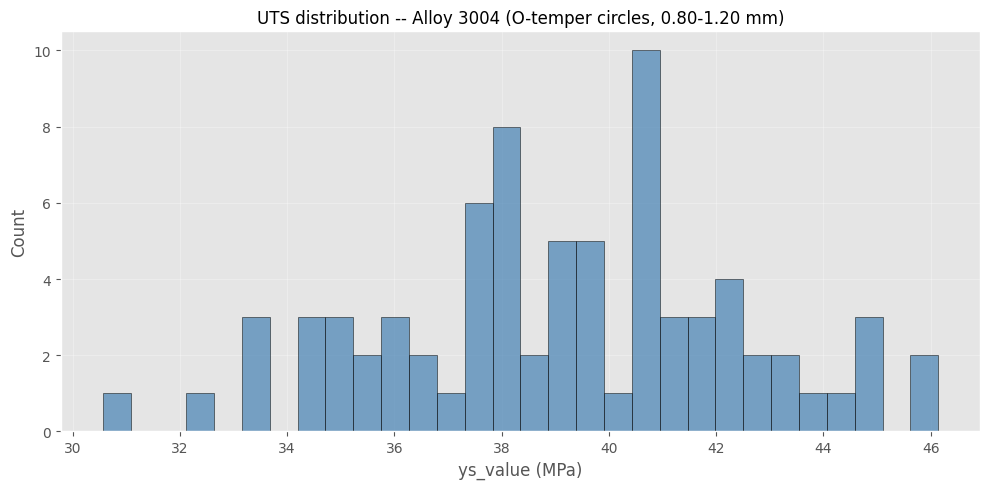


Histogram: 77 samples
  Mean: 39.1 MPa
  Std: 3.3 MPa
  Range: 30.6 - 46.1 MPa


In [8]:
# ============================================================================
# SECTION 5: Example Analysis #2 - Quick Visualization
# ============================================================================

print('\n' + '=' * 80)
print('EXAMPLE ANALYSIS #2: QUICK VISUALIZATION')
print('=' * 80 + '\n')

ALLOY = '3004'
# single_alloy = segment[segment['alloy_code'] == ALLOY]
SEGMENT_TITLE = 'O-temper circles, 0.80-1.20 mm'


fig, ax = plot_uts_histogram(segment,'ys_value',alloy = ALLOY,segment_name=SEGMENT_TITLE)
plt.show()


Boxplot: UTS distribution by alloy (same segment)



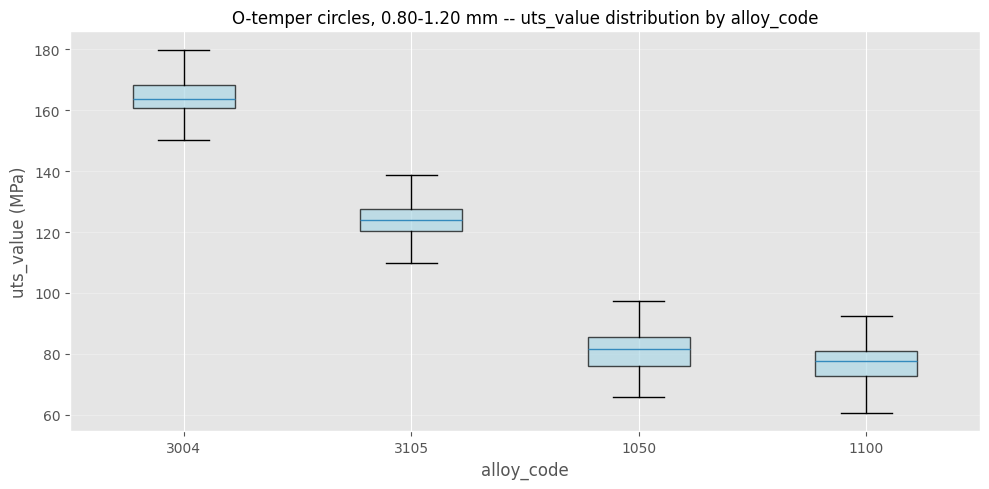


Boxplot by alloy_code: 4 groups


In [9]:
# Boxplot: Compare across alloys
print('\nBoxplot: UTS distribution by alloy (same segment)\n')

fig, ax = plot_uts_boxplot( 
    segment,
    group_col='alloy_code',
    metric_col = 'uts_value',
    segment_name=SEGMENT_TITLE)

plt.show()

## Section 6: Sanity Checks

Quick validation that the dataset is complete and within expected ranges.

In [10]:
# ============================================================================
# SECTION 6: Sanity Checks
# ============================================================================

print('\n' + '=' * 80)
print('SANITY CHECKS')
print('=' * 80 + '\n')

print('Data completeness:')
print(f'  Total heats: {len(df)}')
print(f'  Missing UTS: {df['uts_value'].isna().sum()}')
print(f'  Missing YS: {df['ys_value'].isna().sum()}')
print(f'  Missing YS: {df['elongation_value'].isna().sum()}')

print('\nAlloy distribution:')
print(df['alloy_code'].value_counts().sort_index())

print('\nTemper distribution:')
print(df['base_temper'].value_counts().sort_index())

print('\nUTS statistics:')
print(f'  Range: {df['uts_value'].min():.1f} - {df['uts_value'].max():.1f} MPa')
print(f'  Mean ± Std: {df['uts_value'].mean():.1f} ± {df['uts_value'].std():.1f} MPa')

print('\n✓ Dataset complete and within expected ranges')


SANITY CHECKS

Data completeness:
  Total heats: 2200
  Missing UTS: 0
  Missing YS: 0
  Missing YS: 0

Alloy distribution:
alloy_code
1050    600
1100    600
3004    400
3105    600
Name: count, dtype: int64

Temper distribution:
base_temper
O    1816
f      23
h     361
Name: count, dtype: int64

UTS statistics:
  Range: 50.0 - 187.1 MPa
  Mean ± Std: 106.8 ± 34.4 MPa

✓ Dataset complete and within expected ranges


## Section 7: Closing Notes

### What This Demonstrated

1. **Semantic layer as analytical interface:** Simple joins using `heat_id`
2. **Grain validation:** Heat-level contracts are explicit
3. **Analysis-ready dataset:** Built in 3 lines (pivot + 2 merges)
4. **Reproducible consumption:** CSV or PostgreSQL, same result

### Key Insight

**The semantic layer abstracts away data origin.** Analyst doesn't care whether data comes from CSV or live database. The interface is the same.

### Why This Matters for SC01

- Data quality is enforced upstream (not downstream)
- Analyses are comparable because semantics are stable
- Reproducibility is guaranteed because grain contracts are explicit
- Downstream analyses (SC02-SC05) can trust the foundation

### What Comes Next

- **SC02:** Does chemistry contain predictive signal for UTS?
- **SC03:** Do models generalize across alloy systems?
- **SC04:** Do process variables improve robustness?
- **SC05:** How do we translate models into decision tools?

All downstream studies use this same semantic layer, ensuring consistent, defensible analysis.